In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


Load the .npy file and extract the first frame

uint16


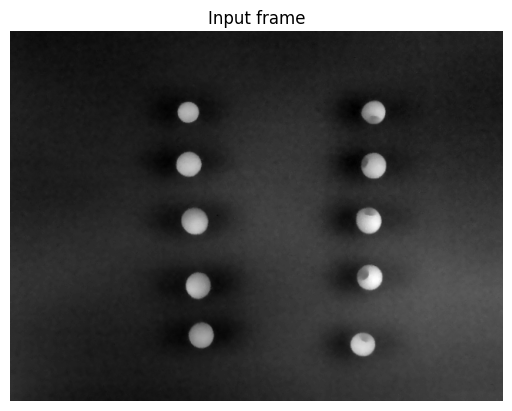

In [3]:
data = np.load('./SavedData/goodbad.npy', allow_pickle=True).astype(np.uint16)
print(data.dtype)
frame = data[400]
plt.imshow(frame, cmap='gray')
plt.title('Input frame')
plt.axis('off')
plt.show()

In [4]:
print('The shape of each frame of data is:',frame.shape)

The shape of each frame of data is: (480, 640)


Preprocess the frame by applying Gaussian blur to reduce noise

(480, 640)
uint16


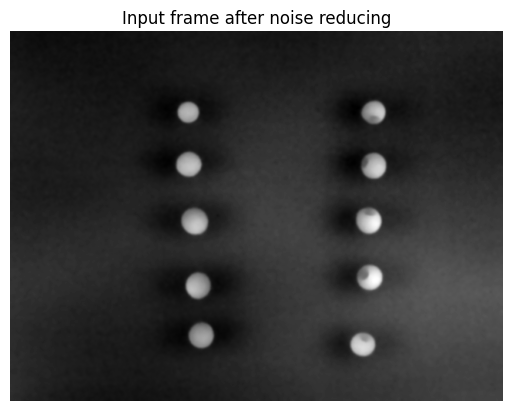

In [5]:
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
print(blurred.shape)
print(blurred.dtype)
plt.imshow(blurred, cmap='gray')
plt.title('Input frame after noise reducing')
plt.axis('off')
plt.show()

uint16


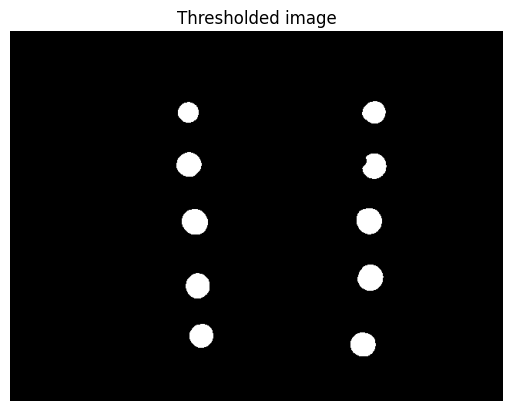

In [6]:
# Choose a threshold value that works well for your image, 8772 is by maual testing
threshold_value = 8772

# Threshold the image
ret, thresh = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)
print(thresh.dtype)

# Display the thresholded image
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded image')
plt.axis('off')
plt.show()

In [7]:
thresh_copy = thresh
def expand_seed(image, x, y):
    seed_positions = []
    dx = [-1, 0, 1, 0]
    dy = [0, -1, 0, 1]

    image[x][y] = 0
    seed_positions.append([x, y])
    for k in range(4):
        new_x, new_y = x + dx[k], y + dy[k]
        if (new_x >= 0 and new_x < 480 and new_y >= 0 and new_y < 640 and image[new_x][new_y] == 255):
            seed_positions += expand_seed(image, new_x, new_y)

    return seed_positions

    


# Initialize the dictionary of seed coordinates
seed_coords = {}
count = 0

# Traverse through all the pixels in the image
for x in range(thresh_copy.shape[0]):
    for y in range(thresh_copy.shape[1]):
        if thresh_copy[x, y] == 255:
            count+=1
            seed_pixels = expand_seed(thresh_copy, x, y)
            seed_name = f'seed {count}'
            seed_coords[seed_name] = seed_pixels

            # Update thresh_copy to remove the expanded seed pixels
            for pixel in seed_pixels:
                thresh_copy[pixel[0], pixel[1]] = 0

for key in seed_coords:
    print(key, len(seed_coords[key]))
print(count)

seed 1 684
seed 2 568
seed 3 806
seed 4 781
seed 5 892
seed 6 894
seed 7 889
seed 8 804
seed 9 757
seed 10 815
10


In [8]:
# change the seeds mapping maually
temp_2 = seed_coords['seed 3']
temp_1 = seed_coords['seed 2']
temp_3 = seed_coords['seed 6']
temp_8 = seed_coords['seed 5']
temp_4 = seed_coords['seed 8']
temp_10 = seed_coords['seed 10']
temp_9 = seed_coords['seed 7']
temp_7 = seed_coords['seed 4']
temp_5 = seed_coords['seed 9']
temp_6 = seed_coords['seed 1']

seeds = {}
seeds['good seed 1'] = temp_1
seeds['good seed 2'] = temp_2
seeds['good seed 3'] = temp_3
seeds['good seed 4'] = temp_4
seeds['good seed 5'] = temp_5
seeds['bad seed 1'] = temp_6
seeds['bad seed 2'] = temp_7
seeds['bad seed 3'] = temp_8
seeds['bad seed 4'] = temp_9
seeds['bad seed 5'] = temp_10

good seed 1
10
good seed 2
30
good seed 3
50
good seed 4
70
good seed 5
90
bad seed 1
110
bad seed 2
130
bad seed 3
150
bad seed 4
170
bad seed 5
190


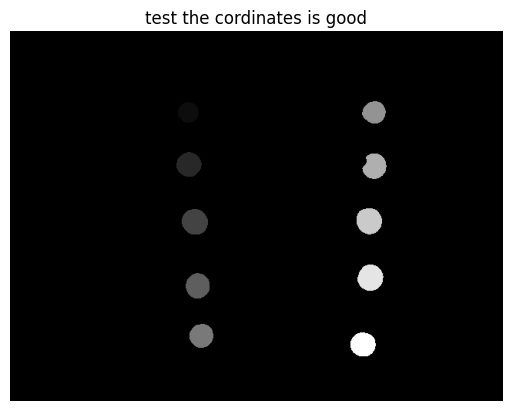

In [9]:
# test whether we are getting the correct map

test_plot = np.zeros((480, 640), dtype=np.uint8)
ploted_val = 10
for key in seeds:
    print(key)
    print(ploted_val)
    for i in range (len(seeds[key])):
        test_plot[seeds[key][i][0]][seeds[key][i][1]] = ploted_val
    ploted_val += 20

plt.imshow(test_plot, cmap='gray')
plt.title('test the cordinates is good')
plt.axis('off')
plt.show()

900
900


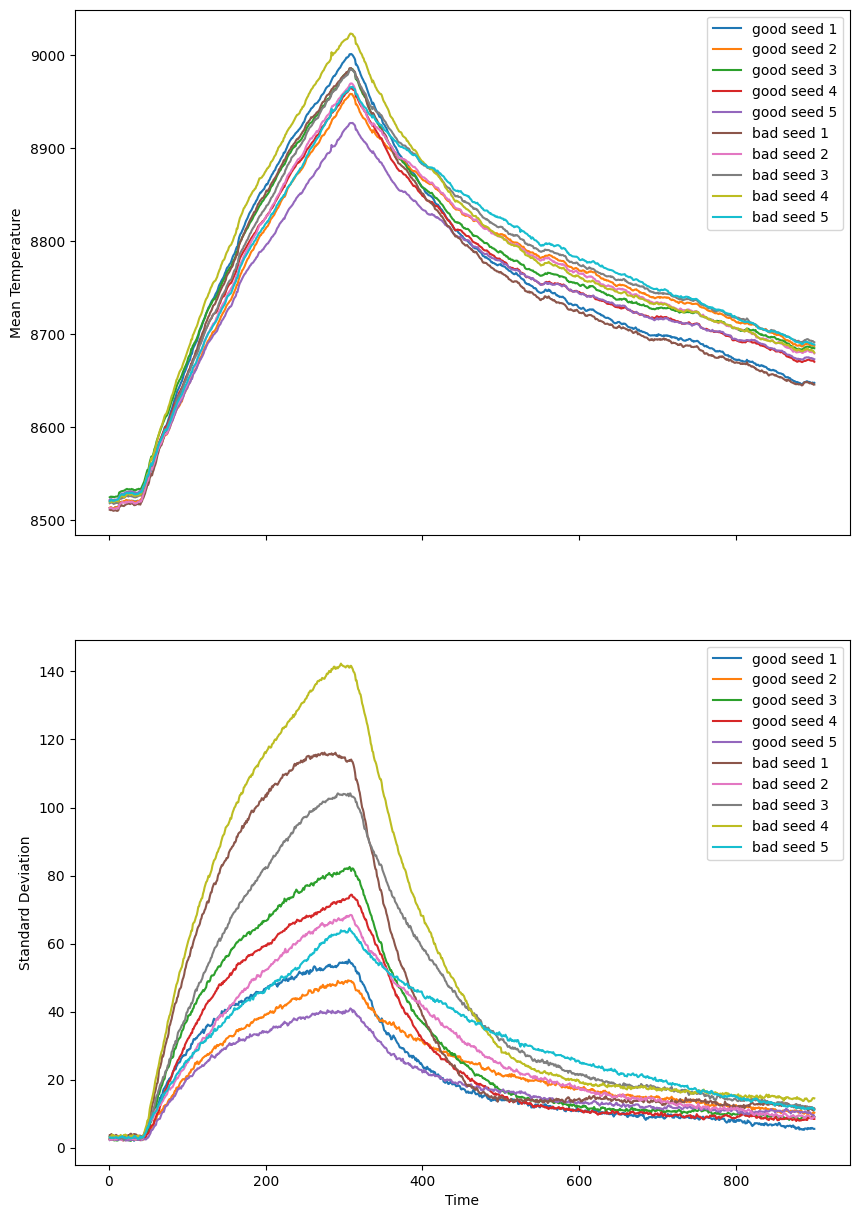

In [10]:
seed_curve_mean = {}
seed_curve_std = {}
for picture in data:
    for tag in seeds:
        tag_size = len(seeds[tag])
        tag_seed_vals = []
        for i in range(tag_size):
            x,y = seeds[tag][i][0], seeds[tag][i][1]
            tag_seed_vals.append(picture[x][y])
        tag_seed_val_mean = np.mean(tag_seed_vals)
        tag_seed_val_std = np.std(tag_seed_vals)
        seed_curve_mean.setdefault(tag, []).append(tag_seed_val_mean)
        seed_curve_std.setdefault(tag, []).append(tag_seed_val_std)

# print(seed_curve)
print(len(seed_curve_mean['good seed 2']))
print(len(seed_curve_std['good seed 2']))

x = list(range(1, 901))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 15))

for tag, values in seed_curve_mean.items():
    ax1.plot(x, values, label=tag)
for tag, values in seed_curve_std.items():
    ax2.plot(x, values, label=tag)


ax1.set_ylabel('Mean Temperature')
ax2.set_ylabel('Standard Deviation')
ax2.set_xlabel('Time')
ax1.legend()
ax2.legend()
plt.show()

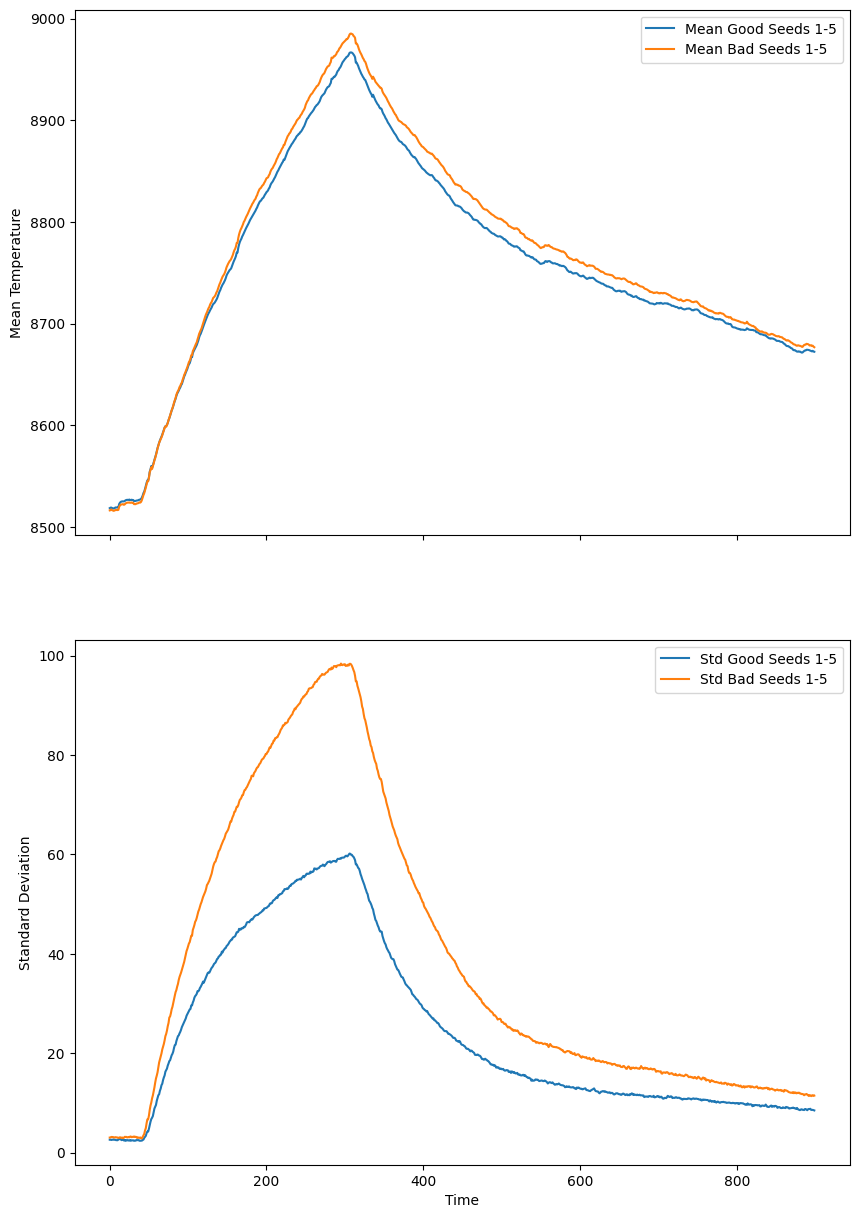

In [11]:
# Create subplots for the mean and standard deviation curves
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 15))

# Plot the mean curves for the first 5 seeds as a group
group1_mean = [seed_curve_mean[tag] for tag in list(seed_curve_mean.keys())[:5]]
ax1.plot(np.mean(group1_mean, axis=0), label='Mean Good Seeds 1-5')
group1_std = [seed_curve_std[tag] for tag in list(seed_curve_std.keys())[:5]]
ax2.plot(np.mean(group1_std, axis=0), label='Std Good Seeds 1-5')

# Plot the mean curves for the last 5 seeds as a group
group2_mean = [seed_curve_mean[tag] for tag in list(seed_curve_mean.keys())[5:]]
ax1.plot(np.mean(group2_mean, axis=0), label='Mean Bad Seeds 1-5')
group2_std = [seed_curve_std[tag] for tag in list(seed_curve_std.keys())[5:]]
ax2.plot(np.mean(group2_std, axis=0), label='Std Bad Seeds 1-5')

# Set the axis labels and legend
ax1.set_ylabel('Mean Temperature')
ax2.set_ylabel('Standard Deviation')
ax2.set_xlabel('Time')
ax1.legend()
ax2.legend()

# Show the plot
plt.show()


In [24]:
np.savetxt('csv_data/badseed1.csv', seed_curve_mean['bad seed 1'], delimiter=',')

In [27]:
import arff
arff.dump('csv_data/goodseed1.arff', 
           zip(seed_curve_mean['good seed 1']), 
           relation='good seed #1 from the goodbad condition', 
           fields=[{'name': 'thermal value', 'type': 'NUMERIC'}])

TypeError: dump() got an unexpected keyword argument 'fields'